# Interpreting Image Classification of Keras InceptionV3

In this notebook, the predictions of a pretrained deep neural network (InceptionV3) are examined using the interpretation method LimeImageExplainer.

* First, Lime is applied to a single prediction to make its concept easier to understand. 
* In the later section it is applied to a group of predictions of the model.

In [1]:
#process not on GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## Loading packages

In [2]:
# Keras
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Tools requiered for visualizing and processing
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
model_InceptionV3 = InceptionV3(weights = 'imagenet')

W0629 00:11:56.638102 140427780687488 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 00:11:56.652045 140427780687488 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 00:11:56.654965 140427780687488 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 00:11:56.671665 140427780687488 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0629 00:11:56.672173 140427780687488 deprecation_wrappe

## Getting started with a single prediction of the model

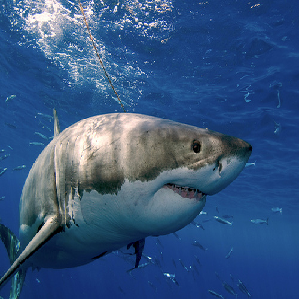

In [4]:
# Load image and scale to 299x299
image_raw = load_img("/home/common_files/datasets/imagenet/pictures/n01484850/n01484850_10798.jpg",target_size = (299,299))
image_raw

In [5]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it.
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [6]:
# Predict
prediction = model_InceptionV3.predict(image)
pd.DataFrame(decode_predictions(prediction, top=3)[0],columns=['col1','class','probability']).iloc[:,1:]

,class,probability
0,great_white_shark,0.938497
1,tiger_shark,0.001046
2,grey_whale,0.000489


## Loading LIME

In [7]:
import lime
from lime.lime_image import LimeImageExplainer
# Requiered segmentatin package for creating superpixel of image
from skimage.segmentation import mark_boundaries, quickshift
import numpy as np

### Create explaination

In [8]:
explainer = LimeImageExplainer()

Number of superpixel:  65


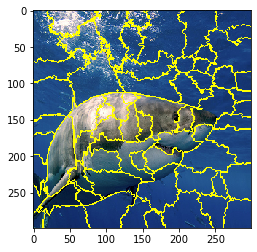

In [9]:
# This part is optional and listed to make clear the idea behind LimeImageExplainer. This means Lime does this automatically
# Lime is creating superpixel using the segmentation algorithm quickshift like below, an
segments = quickshift(image_raw, kernel_size=4, max_dist=200, ratio=0.2,random_seed=42)
superpixel = mark_boundaries(image_raw, segments)
plt.imshow(superpixel)
print('Number of superpixel: ',len(np.unique(segments)))

In [10]:
# pass image as (299,299,3)-Array 299x299Pixel in RGB
explanation = explainer.explain_instance(image[0], model_InceptionV3.predict, top_labels=3, num_samples=500, random_seed=42 )

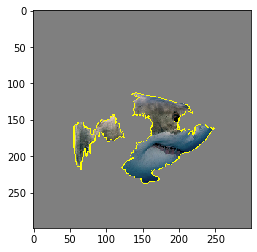

In [11]:
#Show top three Superpixel supported decision making
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,  hide_rest=True)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

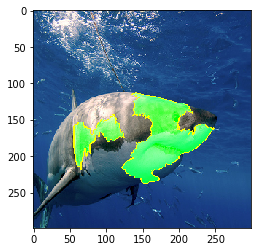

In [12]:
# explanation.top_labels[0] = index of hieghest probable predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,   hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)


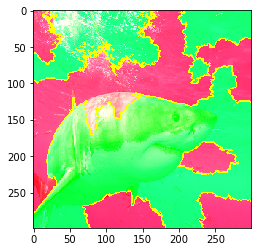

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=len(np.unique(segments)),hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

### Create explanations for a group of predictions

* We predicted 810 992 images (from the ImageNet database) without retraining the model
* Result: Accuracy of 86.9 %
* At the end we created a dataset containing all false predicted images
* Images can be downloaded here : http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz

In [14]:
results_images_df = pd.read_hdf('results-inceptionv3-1.h5',key='pictures')
results_images_df.head(5)

,label_id,label_name1,label_name2,prediction_id,prediction_name1,prediction_name2,file_name,confidence_in_prediction,prediction_in_top_5,confidence_in_label,confidence_difference
0,0,n01440764,tench,651,n03761084,microwave,n01440764/n01440764_10028.jpg,0.689906,False,0.006450,0.683456
0,0,n01440764,tench,389,n02514041,barracouta,n01440764/n01440764_10030.jpg,0.908541,False,0.008006,0.900535
0,0,n01440764,tench,33,n01664065,loggerhead,n01440764/n01440764_1024.jpg,0.087677,False,0.057672,0.030005
0,0,n01440764,tench,391,n02536864,coho,n01440764/n01440764_10553.jpg,0.294498,False,0.022437,0.272061
0,0,n01440764,tench,719,n03935335,piggy_bank,n01440764/n01440764_10744.jpg,0.944047,False,0.005714,0.938332


In [15]:
%%html
<style>
table {float:left}
</style>

### Columns of dataset explained

| Column | Explanation |
| --- | --- |
| label_id | index of actual label |
| label_name1 | encoded actual label |
| label_name2  | decoded actual label |
| prediction_id | index of predicted label |
| prediction_name1 | encoded predicted label |
| prediction_name2 | decoded predicted label |
| file_name | directory of image |
| confidence_in_prediction | probability for predicted label by model |
| prediction_in_top_5 | True, if actual label is in top five of predicted classes, otherwise False |
|confidence_in_label   | probability for actual label predicted by model|
confidence_difference   |confidence_in_prediction - confidence_in_label|

### Define methods for codes above

In [16]:
# To load images
def get_Image(image_dir):
    image = load_img("/home/common_files/datasets/imagenet/pictures/"+image_dir,target_size = (299,299))
    return image    

In [17]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it. 
def preprocess_image(image_raw):
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image[0]

In [18]:
# Create explanation of Image
def explanation_for_instance(image,model):
    explanation = explainer.explain_instance(image,model.predict,top_labels = 1,num_samples=1000,random_seed=42)
    return explanation

In [19]:
# Mask explanation and return top ten superpixel for most probable prediction of model and hide rest of image
def get_explained_image(explanation, positive_only, hide_rest):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = positive_only, num_features=10, hide_rest=hide_rest)
    bounderies = mark_boundaries(temp /2 + .5,mask)
    return bounderies

### Create explanations in loop

* We want to create explanations for only images where confidence_difference is higher than 0.98 since we have more than 100 000 false predictions 
* And it takes to much time generate an explanation for an image

In [ ]:
# Order dataframe by confidence_difference descending to make iteration more efficent
results_images_df = results_images_df.sort_values(['confidence_difference'], ascending=False)

# Create explanation in loop

for i in range(len(results_images_df)):
    
    file_name = results_images_df.iloc[i]['file_name']
    image_raw = get_Image(file_name)
    image = preprocess_image(image_raw)
    explanation = explanation_for_instance(image, model_InceptionV3)
    # get explained image with 10 positive weighted superpixel and hide rest
    explained_image_positive_and_hidden = get_explained_image(explanation, positive_only = True, hide_rest= True)
    # get explained image with 10 positive or negative weigthed superpixel, hide_rest = False
    explained_image_pos_neg = get_explained_image(explanation, positive_only = False, hide_rest= False)
    
    #plt.savefig('../Output_Images/Predicted_ {}, Actual_ {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']))
    
    #plot only first 10
    if i < 10:
        
        fig, ax = plt.subplots(1,3, figsize = (15,15))
        ax[0].imshow(image_raw)
        ax[0].set_title('Predicted: {}, Actual: {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']), fontsize =12)
        ax[1].imshow(explained_image_positive_and_hidden)
        ax[1].set_title('10 most positive superpixel, rest hidden')
        ax[2].imshow(explained_image_pos_neg)
        ax[2].set_title('Positive and negative weighted superpixels')
        plt.show()
    
    if results_images_df.iloc[i]['confidence_difference'] < 0.98:
        break

## LIME vs. Class Activation Maps

* In this section Class Activation Maps are generated and compared with the results of the LimeImageExplainer.

* Class Activation Maps are simple to implement and can help to get the discriminative image regions used by a CNN to identify a specific class in the image. 

* Class Activation Maps are often called as Attention Maps

### Get Class Activation Map for a single prediction

In [20]:
# import keras-vis
import vis
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam
from keras import activations
from PIL import Image

(299, 299, 3)

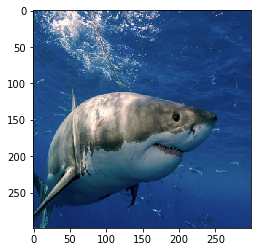

In [21]:
image_raw = utils.load_img("/home/common_files/datasets/imagenet/pictures/n01484850/n01484850_10798.jpg",target_size = (299,299))
plt.imshow(image_raw)
image_raw.shape

In [22]:
#Preprocess input
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [23]:
# predict
prediction =  model_InceptionV3.predict(image)
# get corrosponding imagenet index for prediction
argmax = np.argmax(prediction[0])
print('ImageNet Index for prediction: ',argmax)
decode_predictions(prediction)

ImageNet Index for prediction:  2


[[('n01484850', 'great_white_shark', 0.9267559),
  ('n01491361', 'tiger_shark', 0.0018592565),
  ('n02058221', 'albatross', 0.00045467066),
  ('n02071294', 'killer_whale', 0.0004483221),
  ('n02066245', 'grey_whale', 0.0003916999)]]

In [24]:
# get last layer
prediction_layer = model_InceptionV3.get_layer('predictions')
prediction_layer

In [25]:
# get index of last layer
prediction_layer_idx = utils.find_layer_idx(model_InceptionV3, 'predictions')
prediction_layer_idx

312

(299, 299, 3)

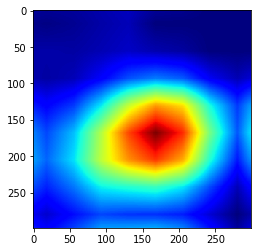

In [26]:
# filter_indices is the corresponding label index for great_white_share
cam = visualize_cam(model=model_InceptionV3, layer_idx=prediction_layer_idx, filter_indices=argmax, seed_input=image)
plt.imshow(cam)
cam.shape

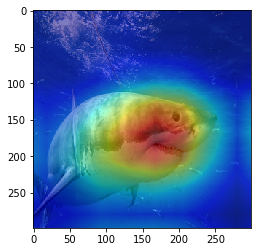

In [27]:
plt.imshow(overlay(image_raw,cam, alpha=0.5))

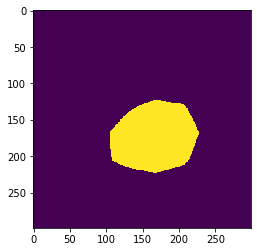

In [28]:
# Get the red area of the attention_map (most positive area for classification of cnn)
# initialize 3D-array of zeros 299x299Pixel RGB
cam_mask = np.zeros((299,299))

# fill array, where blue channel is 0
mask = cam[:,:,2] == 0

# Set to 1 the pixels where mask is True
cam_mask[mask] = 1
plt.imshow(cam_mask)

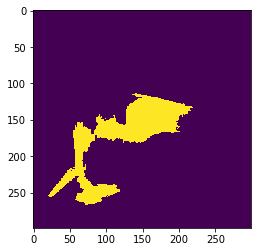

In [29]:
# get lime mask for top 5 superpixel of actual label

#first create explanation the image index of great white shark (labels = (2,))
explanation = explainer.explain_instance(image[0], model_InceptionV3.predict,num_samples = 500, labels = (argmax,), top_labels = None)
temp, LimeMask = explanation.get_image_and_mask(argmax, positive_only = True,  hide_rest = True)
boundaries = mark_boundaries(temp / 2 + .5, LimeMask)
plt.imshow(LimeMask)


In [30]:
cam_mask
cam_mask.shape

(299, 299)

### Compare both masks

![IntersectionLIME_CAM](Intersection_LIME_CAM.png)


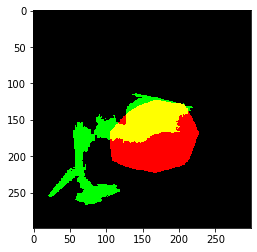

In [31]:
# Compare both masks
masks = np.zeros((299,299,3))
masks[:,:,0] = cam_mask
masks[:,:,1] = LimeMask
plt.imshow(masks)

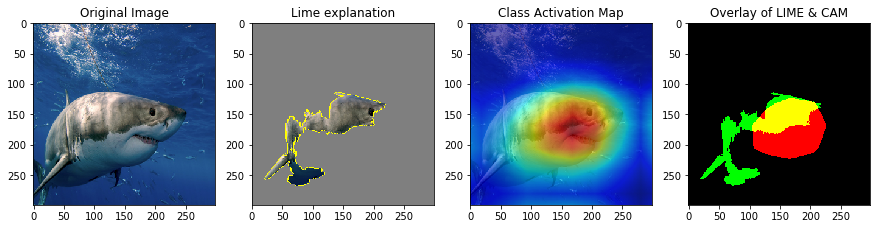

Overlay of LIME and Class Activation Map:

Pixel in intersection (Yellow): 3853 
Pixel only in CAM (Red): 	5496 
Pixel only in LIME (Green): 	4163 
Match in percentage (Yellow): 	0.285153937240971


In [32]:
# Pixel in intersection (Yellow)


pixel_intersection = ((LimeMask + cam_mask) == 2).sum()

# Totalpixel_attentionMap without intersection
pixel_Cam = (cam_mask == 1).sum() - pixel_intersection 

# Totalpixel Lime without intersection
pixel_Lime = (LimeMask == 1 ).sum() - pixel_intersection

# Get match in percentage (Yellow)
match_in_percent = pixel_intersection / (pixel_Lime + pixel_Cam + pixel_intersection)

fig, ax = plt.subplots(1,4, figsize = (15,15))

ax[0].imshow(image_raw)
ax[0].set_title('Original Image')
ax[1].imshow(boundaries)
ax[1].set_title('Lime explanation')
ax[2].imshow(overlay(image_raw,cam, alpha=0.4))
ax[2].set_title('Class Activation Map')
ax[3].imshow(masks)
ax[3].set_title('Overlay of LIME & CAM')

plt.show()
print('Overlay of LIME and Class Activation Map:\n')
print('Pixel in intersection (Yellow): {} \nPixel only in CAM (Red): \t{} \nPixel only in LIME (Green): \t{} \nMatch in percentage (Yellow): \t{}'.format(pixel_intersection,pixel_Cam, pixel_Lime,match_in_percent))

## Get code above in methods and create explanations for group of predictions

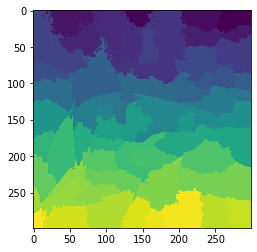

In [33]:
plt.imshow(explanation.segments)

In [44]:
import h5py

dataSetNames = []
dataSets = {}

if os.path.isfile('bounding_box_results.h5'):
    with h5py.File('bounding_box_results.h5', 'r') as hf:
        dataSetsRAW = hf.keys()        
        for x in dataSetsRAW:
            dataSetNames.append(x)
            dataSets[x] = pd.read_hdf('bounding_box_results.h5', key = x)
        print(dataSetsRAW)
print(dataSetNames)


<KeysViewHDF5 ['n01443537', 'n01580077', 'n01631663', 'n01695060', 'n01704323', 'n01773797', 'n01798484', 'n01955084', 'n02089867', 'n02093859', 'n02095314', 'n02096051', 'n02096437', 'n02098105', 'n02099601', 'n02100735', 'n02105641', 'n02105855', 'n02111500', 'n02117135', 'n02119789', 'n02130308', 'n02177972', 'n02268443', 'n02276258', 'n02281406', 'n02488702', 'n02643566', 'n02783161', 'n02791124', 'n02807133', 'n02837789', 'n02892767', 'n02951358', 'n03041632', 'n03085013', 'n03109150', 'n03250847', 'n03325584', 'n03599486', 'n03775546', 'n03788365', 'n03804744', 'n04005630', 'n04023962', 'n04044716', 'n04136333', 'n04146614', 'n04443257', 'n04507155', 'n06874185', 'n07697537', 'n10148035']>
['n01443537', 'n01580077', 'n01631663', 'n01695060', 'n01704323', 'n01773797', 'n01798484', 'n01955084', 'n02089867', 'n02093859', 'n02095314', 'n02096051', 'n02096437', 'n02098105', 'n02099601', 'n02100735', 'n02105641', 'n02105855', 'n02111500', 'n02117135', 'n02119789', 'n02130308', 'n021779

In [45]:
dataSets['n01443537'].head(10)

,LimeMask,boundingBoxes,filename,imageClass,imageClassID,percentageLimeMaskInBoundingBox,pixelBothMasks,pixelOnlyBoundingBoxMask,pixelOnlyLimeMask,prediction
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 0, 'ymin': 0, 'xmax': 99, 'ymax': 62...",n01443537_2342.jpg,n01443537,1,0.978462,17309,69715,381,"[3.925853e-05, 0.99368954, 8.277302e-07, 5.861..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 2, 'ymin': 6, 'xmax': 306, 'ymax': 2...",n01443537_1135.jpg,n01443537,1,0.987850,6098,80032,75,"[4.2911197e-05, 0.99874735, 1.9958433e-07, 4.4..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 111, 'ymin': 104, 'xmax': 603, 'ymax...",n01443537_605.jpg,n01443537,1,0.892634,9137,31573,1099,"[6.0670286e-06, 0.99793303, 5.4857395e-07, 1.0..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 26, 'ymin': 2, 'xmax': 347, 'ymax': ...",n01443537_2312.jpg,n01443537,1,1.000000,10149,56811,0,"[5.7549878e-05, 0.9769066, 6.419384e-06, 3.410..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 207, 'ymin': 78, 'xmax': 498, 'ymax'...",n01443537_6592.jpg,n01443537,1,0.999725,10909,28937,3,"[5.2319942e-06, 0.998679, 4.2285228e-07, 2.425..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 95, 'ymin': 24, 'xmax': 464, 'ymax':...",n01443537_11078.jpg,n01443537,1,0.999042,9388,52271,9,"[0.00011545935, 0.98561364, 1.9777062e-05, 1.8..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 102, 'ymin': 102, 'xmax': 328, 'ymax...",n01443537_17105.jpg,n01443537,1,0.808110,11977,18647,2844,"[0.00013864937, 0.980702, 2.1607708e-05, 0.000..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 134, 'ymin': 108, 'xmax': 445, 'ymax...",n01443537_5014.jpg,n01443537,1,0.921834,7701,22285,653,"[3.103774e-05, 0.9911185, 4.314033e-06, 1.3419..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 257, 'ymin': 155, 'xmax': 422, 'ymax...",n01443537_8475.jpg,n01443537,1,0.386983,2515,7880,3984,"[5.6444067e-05, 0.99530715, 3.5775718e-06, 5.8..."
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'xmin': 251, 'ymin': 75, 'xmax': 397, 'ymax'...",n01443537_16813.jpg,n01443537,1,0.214809,2347,2786,8579,"[0.00082093733, 0.578035, 0.0005160068, 0.0002..."


In [71]:
def getMaskLime(path,ImageIndex):
    #/home/common_files/datasets/imagenet/pictures/n01484850/n01484850_10798.jpg
    #Preprocess input
    image_raw = utils.load_img(path,target_size = (299,299))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    explanation = explainer.explain_instance(image[0], model_InceptionV3.predict,num_samples = 500, labels = (ImageIndex,), top_labels = None)
    temp, LimeMask = explanation.get_image_and_mask(ImageIndex, positive_only = True,  hide_rest = True)
    boundaries = mark_boundaries(temp / 2 + .5, LimeMask)
    #plt.imshow(LimeMask)
    
    return LimeMask, boundaries

In [59]:
def getMaskCAM(path,ImageIndex):
    
    image_raw = load_img(path,target_size = (299,299))
    # Preprocess image in an array to make it compatible with the Keras model and reshape it.
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam_mask = np.zeros((299,299))
    cam = visualize_cam(model_InceptionV3, layer_idx=prediction_layer_idx, filter_indices=ImageIndex, seed_input=image)
    # fill array, where blue channel is 0
    mask = cam[:,:,2] == 0
    # Set to 1 the pixels where mask is True
    cam_mask[mask] = 1
    
    return cam_mask, cam

In [60]:
def compareMasks(LimeMask,cam_mask):
    # Pixel in intersection (Yellow)
    # Compare both masks
    masks = np.zeros((299,299,3))
    masks[:,:,0] = cam_mask
    masks[:,:,1] = LimeMask

    pixel_intersection = ((LimeMask + cam_mask) == 2).sum()

    # Totalpixel_attentionMap without intersection
    pixel_Cam = (cam_mask == 1).sum() - pixel_intersection 

    # Totalpixel Lime without intersection
    pixel_Lime = (LimeMask == 1 ).sum() - pixel_intersection

    # Get match in percentage (Yellow)
    match_in_percent = pixel_intersection / (pixel_Lime + pixel_Cam + pixel_intersection)

    #fig, ax = plt.subplots(1,4, figsize = (15,15))

    #ax[0].imshow(image_raw)
    #ax[0].set_title('Original Image')
    #ax[1].imshow(boundaries)
    #ax[1].set_title('Lime explanation')
    #ax[2].imshow(overlay(image_raw,cam, alpha=0.4))
    #ax[2].set_title('Class Activation Map')
    #ax[3].imshow(masks)
    #ax[3].set_title('Overlay of LIME & CAM')

    #plt.show()
    #print('Overlay of LIME and Class Activation Map:\n')
    #print('Pixel in intersection (Yellow): {} \nPixel only in CAM (Red): \t{} \nPixel only in LIME (Green): \t{} \nMatch in percentage (Yellow): \t{}'.format(pixel_intersection,pixel_Cam, pixel_Lime,match_in_percent))
    
    return masks,pixel_intersection,pixel_Lime,pixel_Cam, match_in_percent

In [61]:
classJSON = "/home/visalf/.keras/models/imagenet_class_index.json"

with open(classJSON) as json_file:
    labelList = json.load(json_file)
inversLabelList = {}
for classID, value in labelList.items():
    inversLabelList[value[0]] = int(classID)

In [62]:
def getPrediction(pathToImage):
    image_raw = load_img(pathToImage, target_size = (299,299))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    prediction = model_InceptionV3.predict(image)
    return (prediction[0])

In [ ]:
basePath = '/home/common_files/datasets/imagenet/pictures'
resultsDF = pd.DataFrame()
i = 0
for dir_, subfolder, file_name in os.walk(basePath):
    
    for className in subfolder:
        classPaths = os.path.join(dir_,className) 

        for dir_, s, file_name in os.walk(classPaths):

            for file in file_name:
                i += 1
                pathToImage = os.path.join(dir_, file)
                image_raw = utils.load_img(pathToImage, target_size=(299,299))
                imageIndex = inversLabelList[className]
                limeMask, boundaries = getMaskLime(pathToImage, imageIndex)
                camMask, camMap = getMaskCAM(pathToImage, imageIndex)
                bothMasks, pixel_intersection, pixel_Lime, pixel_Cam, match_in_percent = compareMasks(limeMask, camMask)
                prediction = getPrediction(pathToImage)
                
                
                data = {
                    
                    'LimeMask' : [limeMask],
                    'camMask' : [camMask],
                    'file_name': [file],
                    'imageClass': [className],
                    'imageClassID' : [imageIndex],
                    'percentageLimeInCam' : [match_in_percent*100],
                    'pixelIntersectionLimeCam' : [pixel_intersection],
                    'pixelOnlyLime' : [pixel_Lime],
                    'pixelOnlyCam' : [pixel_Cam],
                    'prediction' : [prediction]
                    
                }
                resultsDF = resultsDF.append(pd.DataFrame(data),ignore_index = False)
                if i < 10:
                    print('file: ', file)
                    fig, ax = plt.subplots(1,4, figsize = (15,15))
                    ax[0].imshow(image_raw)
                    ax[0].set_title('Original Image')
                    ax[1].imshow(boundaries)
                    ax[1].set_title('Lime explanation')
                    ax[2].imshow(overlay(image_raw,camMap, alpha=0.4))
                    ax[2].set_title('Class Activation Map')
                    ax[3].imshow(bothMasks)
                    ax[3].set_title('Overlay of LIME & CAM')
                    plt.show()
                    
                    
                    print('Overlay of LIME and Class Activation Map:\n')
                    print('Pixel in intersection (Yellow): {} \nPixel only in CAM (Red): \t{} \nPixel only in LIME (Green): \t{} \nMatch in percentage (Yellow): \t{}'.format(pixel_intersection,pixel_Cam, pixel_Lime,match_in_percent))
                
        
                #print('className: ', className)
                #print('index____: ', inversLabelList[className])
                #print('file: ',file)
                #print('x', os.path.join(dir_, file))

    resultsDF.to_hdf('results_lime_cam.h5', key = className)

In [69]:
resultsDF

""
